## An image segmentation example

In [1]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Rescaling
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

In [3]:
input_img_paths = []

for image in os.listdir(input_dir):
    if (image.endswith(".jpg")):
        input_img_paths.append(os.path.join(input_dir, image))
        
input_img_paths = sorted(input_img_paths)

In [4]:
target_paths = []

for image in os.listdir(target_dir):
    if image.endswith(".png") and not image.startswith("."):
        target_paths.append(os.path.join(target_dir, image))

target_paths = sorted(target_paths)

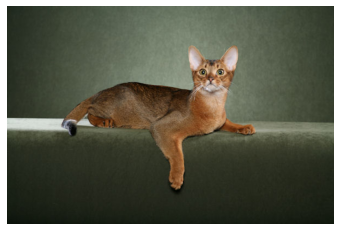

In [5]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[0]))

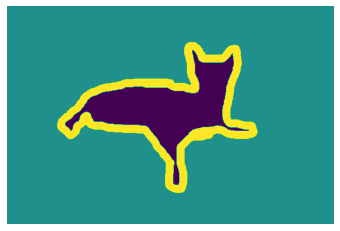

In [6]:
def display_target(image):
    
    normalized_array = (image.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array)

image = img_to_array(load_img(target_paths[0], color_mode="grayscale"))
display_target(image)

In [7]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

In [8]:
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [9]:
def path_to_input_image(path):
    
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    
    return img_to_array(load_img(path, target_size=img_size, color_mode="grayscale")).astype("uint8") - 1

In [10]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [11]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [13]:
inputs = Input(shape=img_size + (3,))
    
x = Rescaling(1./255)(inputs)

x = Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)

x = Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
x = Conv2D(128, 3, activation="relu", padding="same")(x)

x = Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
x = Conv2D(256, 3, activation="relu", padding="same")(x)

x = Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
x = Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
x = Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
x = Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

outputs = Conv2D(3, 3, activation="softmax", padding="same")(x)

model = Model(inputs, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 256)       295168

In [15]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
400/400 [==============================] - 53s 119ms/step - loss: 0.9221 - val_loss: 0.7686
Epoch 2/50
400/400 [==============================] - 45s 112ms/step - loss: 0.7564 - val_loss: 0.7147
Epoch 3/50
400/400 [==============================] - 45s 112ms/step - loss: 0.6520 - val_loss: 1.5713
Epoch 4/50
400/400 [==============================] - 45s 113ms/step - loss: 0.5694 - val_loss: 0.5063
Epoch 5/50
400/400 [==============================] - 46s 114ms/step - loss: 0.5216 - val_loss: 0.5423
Epoch 6/50
400/400 [==============================] - 46s 115ms/step - loss: 0.4904 - val_loss: 0.4548
Epoch 7/50
400/400 [==============================] - 46s 114ms/step - loss: 0.4612 - val_loss: 0.4320
Epoch 8/50
400/400 [==============================] - 46s 114ms/step - loss: 0.4383 - val_loss: 0.4278
Epoch 9/50
400/400 [==============================] - 46s 114ms/step - loss: 0.4171 - val_loss: 0.4887
Epoch 10/50
400/400 [==============================] - 46s 114ms/step - l

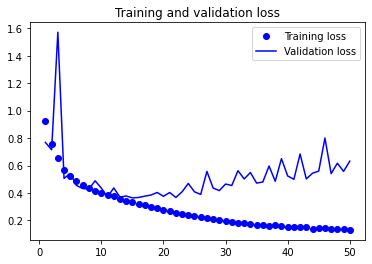

In [16]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 [==============================] - 1s 644ms/step


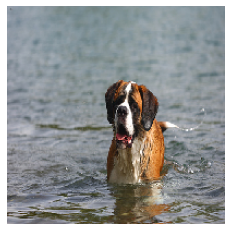

In [17]:
model = load_model("oxford_segmentation.keras")

i = 0
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

pred = model.predict(np.expand_dims(test_image, 0))[0]

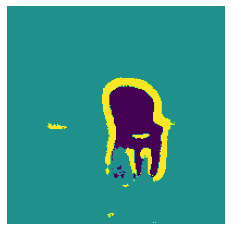

In [18]:
mask = np.argmax(pred, axis=-1)
mask *= 127
plt.axis("off")
plt.imshow(mask)